In [34]:
import pandas
pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from astropy.table import Table

In [35]:
def read_molfit(filename):
    # Read in a molfit file (XCLASS-readable) and translate it to a pandas dataframe
    parnames = ['size', 'T_kin', 'N_tot', 'width', 'vcen']
    with open(filename, 'r') as fh:
        data = {}
        for row in fh:
            if row.lstrip().startswith("%"):
                pass
            elif ';' in row:
                molname = row.split(';', 1)[0] # Changed this to match my formatting
            else:
                els = row.split()
                if len(els) == 0:
                    continue
                # print(els)
                data[molname] = {pn: float(els[ii*4+3]) for ii, pn in enumerate(parnames)}
    tbl = pandas.DataFrame(data).T
    tbl = tbl.rename_axis('Species').reset_index()
    return tbl

In [36]:
# Import Brick core and frown data
tbl = pandas.read_csv('https://docs.google.com/spreadsheets/d/1B4sHLf_wz-8dLeuXcpQO7iRED7mK7Phk61SxGWw5Bok/export?format=csv&gid=1245265514')
tbl.replace('-', np.NaN, inplace=True)
tbl['core\nN_tot, cm^-2'] = np.log10(tbl['core\nN_tot, cm^-2'].astype('float'))
tbl['frown\nN_tot, cm^-2'] = np.log10(tbl['frown\nN_tot, cm^-2'].astype('float'))
# Exclude non-primary velocity components for certain molecules
tbl = tbl.loc[~((tbl['Species'] == 'H2CS') & (tbl['frown\nv_c, km/s'] == '39.5'))] # Exclude H2CS frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'OCS') & (tbl['frown\nv_c, km/s'] == '39.5'))] # Exclude OCS frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'CH2NH') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude CH2NH frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'NH2CHO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude NH2CHO frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'HNCO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HNCO frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'SO2') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude SO2 frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'H2CO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude H2CO frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'H213CO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude H213CO frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'H2COH+') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude H2COH+ frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'CCH') & (tbl['frown\nv_c, km/s'] == '41'))] # Exclude CCH frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'HOCO+') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HOCO+ frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'H2CCO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HOCO+ frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'c-C3H2') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HOCO+ frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'C2H5OH') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HOCO+ frown high v component
tbl = tbl.loc[~((tbl['Species'] == 'CH3CHO') & (tbl['frown\nv_c, km/s'] == '40'))] # Exclude HOCO+ frown high v component
# tbl
# Import Desmond's DSi and DSii data
tbl_dj_ds1 = pandas.read_csv('DSi_estcomcolumns.txt', delimiter=' ')
tbl_dj_ds2 = pandas.read_csv('DSii_estcomcolumns.txt', delimiter=' ')
tbl_dj = pandas.merge(tbl_dj_ds1, tbl_dj_ds2, on=['Species','Note'])
# tbl_dj
# Import Camille's W51 data
tbl_cb = read_molfit('camille_template_test.molfit.txt')
# tbl_cb
# Import Melisse's Sgr B2 N data
tbl_mb_n2 = pandas.read_csv('source_N2.molfit.txt', delimiter=' ')
tbl_mb_n3 = pandas.read_csv('source_N3.molfit.txt', delimiter=' ')
tbl_mb_n4 = pandas.read_csv('source_N4.molfit.txt', delimiter=' ')
tbl_mb_n5 = pandas.read_csv('source_N5.molfit.txt', delimiter=' ')
# Merge Melisse's data on Sgr B2 N into one table
tbl_mb1 = pandas.merge(tbl_mb_n2, tbl_mb_n3, on='Species', how='outer')
tbl_mb2 = pandas.merge(tbl_mb1, tbl_mb_n4, on='Species', how='outer')
tbl_mb = pandas.merge(tbl_mb2, tbl_mb_n5, on='Species', how='outer')
# tbl_mb
# Merge Brick, DSi, W51, and Sgr B2 N data
tbl_merge1 = pandas.merge(tbl, tbl_dj, on='Species', how='outer')
tbl_merge2 = pandas.merge(tbl_merge1, tbl_cb, on='Species', how='outer')
tbl_merged = pandas.merge(tbl_merge2, tbl_mb, on='Species', how='outer')
# tbl_merged
# Sort merged data by ascending Brick core column density
tbl_sorted = tbl_merged.sort_values('core\nN_tot, cm^-2', ascending=True)
# tbl_sorted
# Create a table of just COMs common to Brick core and frown, DSi, W51 core, and Sgr B2 N cores
tbl_coms1 = pandas.merge(tbl, tbl_dj, how='outer')
tbl_coms2 = pandas.merge(tbl_coms1, tbl_cb, how='outer')
tbl_coms = pandas.merge(tbl_coms2, tbl_mb, how='inner')
tbl_coms = tbl_coms.sort_values('core\nN_tot, cm^-2', ascending=True)
# tbl_coms
# Create tables without upper limit molecules (only detections), and with just upper limits
tbl_noUL = tbl_sorted.loc[(tbl_sorted['core'] != 'UL') | (tbl_sorted['frown'] != 'UL')]
tbl_UL = tbl_sorted.loc[(tbl_sorted['core'] == 'UL') | (tbl_sorted['frown'] == 'UL')]

In [37]:
# Extract methanol column densities in each source
Ntot_methanol_core = (10**tbl_noUL.loc[tbl_noUL['Species'] == 'CH3OH', 'core\nN_tot, cm^-2']).item()
Ntot_methanol_frown = (10**tbl_noUL.loc[tbl_noUL['Species'] == 'CH3OH', 'frown\nN_tot, cm^-2']).item()
Ntot_methanol_d1 = (10**tbl_noUL.loc[tbl_noUL['Species'] == 'CH3OH', 'DSi_log10(Ntot)']).item()
Ntot_methanol_d2 = (10**tbl_noUL.loc[tbl_noUL['Species'] == 'CH3OH', 'DSii_log10(Ntot)']).item()
Ntot_methanol_cb = (tbl_noUL.loc[tbl_noUL['Species'] == 'CH3OH', 'N_tot']).item()
Ntot_methanol_n2 = (tbl_coms.loc[tbl_coms['Species'] == 'CH3OH', 'N2']).item()
Ntot_methanol_n3 = (tbl_coms.loc[tbl_coms['Species'] == 'CH3OH', 'N3']).item()
Ntot_methanol_n4 = (tbl_coms.loc[tbl_coms['Species'] == 'CH3OH', 'N4']).item()
Ntot_methanol_n5 = (tbl_coms.loc[tbl_coms['Species'] == 'CH3OH', 'N5']).item()

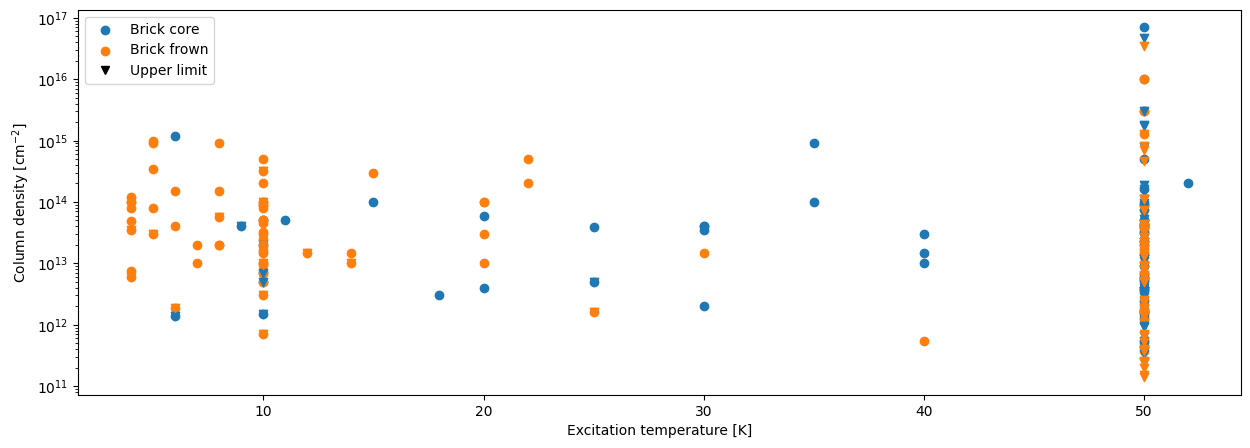

In [38]:
# Plot column density against excitation temperature for all molecules (including upper limts)
fig = plt.figure(figsize = (15, 5))
plt.scatter(tbl_noUL['core T_rot, K'].astype('float'), 
            10**tbl_noUL['core\nN_tot, cm^-2'].astype('float'), marker='o', label="Brick core", color='tab:blue') # Could use masking instead if all in one array
plt.scatter(tbl_noUL['frown T_rot, K'].astype('float'), 
            10**tbl_noUL['frown\nN_tot, cm^-2'].astype('float'), marker='o', label="Brick frown", color='tab:orange')
plt.scatter(tbl_UL['core T_rot, K'].astype('float'), 
            10**tbl_UL['core\nN_tot, cm^-2'].astype('float'), marker='v', color='tab:blue')
plt.scatter(tbl_UL['frown T_rot, K'].astype('float'), 
            10**tbl_UL['frown\nN_tot, cm^-2'].astype('float'), marker='v', color='tab:orange')
plt.ylabel(r"Column density [cm$^{-2}$]")
plt.semilogy()
plt.xlabel("Excitation temperature [K]")
# Make legend
down_arrow = mlines.Line2D([], [], color='k', marker='v', linestyle='None', label='Upper limit')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(down_arrow)
labels.append(down_arrow.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_vs_Tex.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

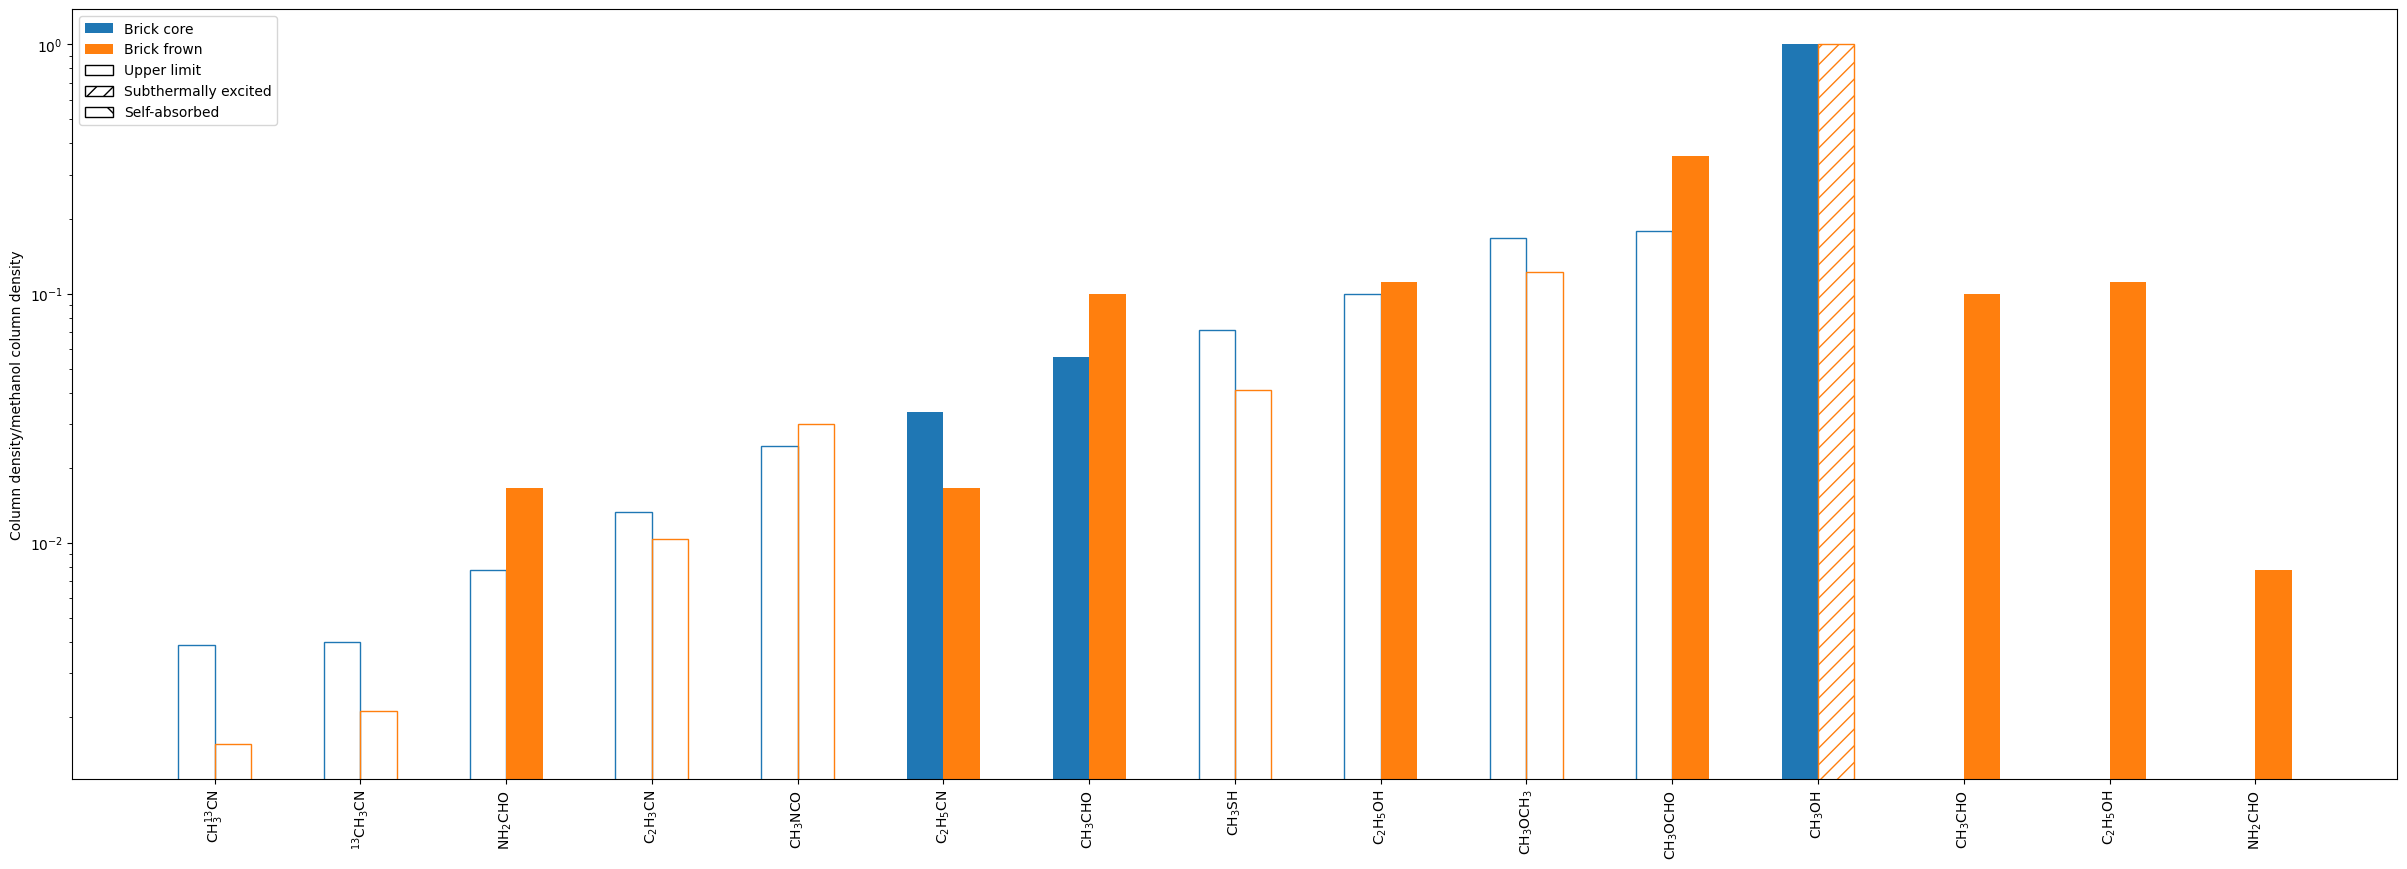

In [39]:
# Plot column density (normalized against methanol) for COMS in Brick core and frown, DSi, W51 core, and Sgr B2 N cores
fig = plt.figure(figsize = (30, 10))
align = 'edge' # center
x_axis = np.arange(len(tbl_coms['core\nN_tot, cm^-2']))
new_x_axis = np.array([2*i for i in x_axis])
var_c = plt.bar(new_x_axis - 0.5, # - 1
                10**tbl_coms['core\nN_tot, cm^-2'].astype('float')/Ntot_methanol_core, width=0.5, align=align, # width=0.25
                label='Brick core', color='tab:blue')
var_f = plt.bar(new_x_axis, # - 0.75
                10**tbl_coms['frown\nN_tot, cm^-2'].astype('float')/Ntot_methanol_frown, width=0.5, align=align, # width=0.25
                label='Brick frown', color='tab:orange')
# plt.bar(new_x_axis - 0.5,
#         tbl_coms['N2']/Ntot_methanol_n2, width=0.25, align=align, label='Sgr B2 N2', color='tab:green')
# plt.bar(new_x_axis - 0.25,
#         tbl_coms['N3']/Ntot_methanol_n3, width=0.25, align=align, label='Sgr B2 N3', color='tab:red')
# plt.bar(new_x_axis,
#         tbl_coms['N4']/Ntot_methanol_n4, width=0.25, align=align, label='Sgr B2 N4', color='tab:purple')
# plt.bar(new_x_axis + 0.25,
#         tbl_coms['N5']/Ntot_methanol_n5, width=0.25, align=align, label='Sgr B2 N5', color='tab:brown')
# plt.bar(new_x_axis + 0.5,
#         10**tbl_coms['DSi_log10(Ntot)']/Ntot_methanol_d1, width=0.25, align=align, label='Sgr B2 DSi', color='tab:pink')
# plt.bar(new_x_axis + 0.75,
#         10**tbl_coms['DSii_log10(Ntot)']/Ntot_methanol_d2, width=0.25, align=align, label='Sgr B2 DSii', color='tab:grey')
# plt.bar(new_x_axis + 1,
#         tbl_coms['N_tot']/Ntot_methanol_cb, width=0.25, align=align, label='W51 core', color='tab:olive')
plt.yscale("log")
plt.xticks(new_x_axis, tbl_coms['Species_latex'], rotation=90)
plt.ylabel(r"Column density/methanol column density")
# Make legend
upper_limit = mpatches.Patch(edgecolor='k', facecolor='None', label='Upper limit')
subt_exc = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '//', label='Subthermally excited')
self_abs = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '\\', label='Self-absorbed')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(upper_limit)
handles.append(subt_exc)
handles.append(self_abs)
labels.append(upper_limit.get_label())
labels.append(subt_exc.get_label())
labels.append(self_abs.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
# Change marker types that are plotted
for rect,row in zip(var_c, Table.from_pandas(tbl_coms)):
    if row['core'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['core'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['core'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
for rect,row in zip(var_f, Table.from_pandas(tbl_coms)):
    if row['frown'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['frown'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['frown'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_COMS_norm.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

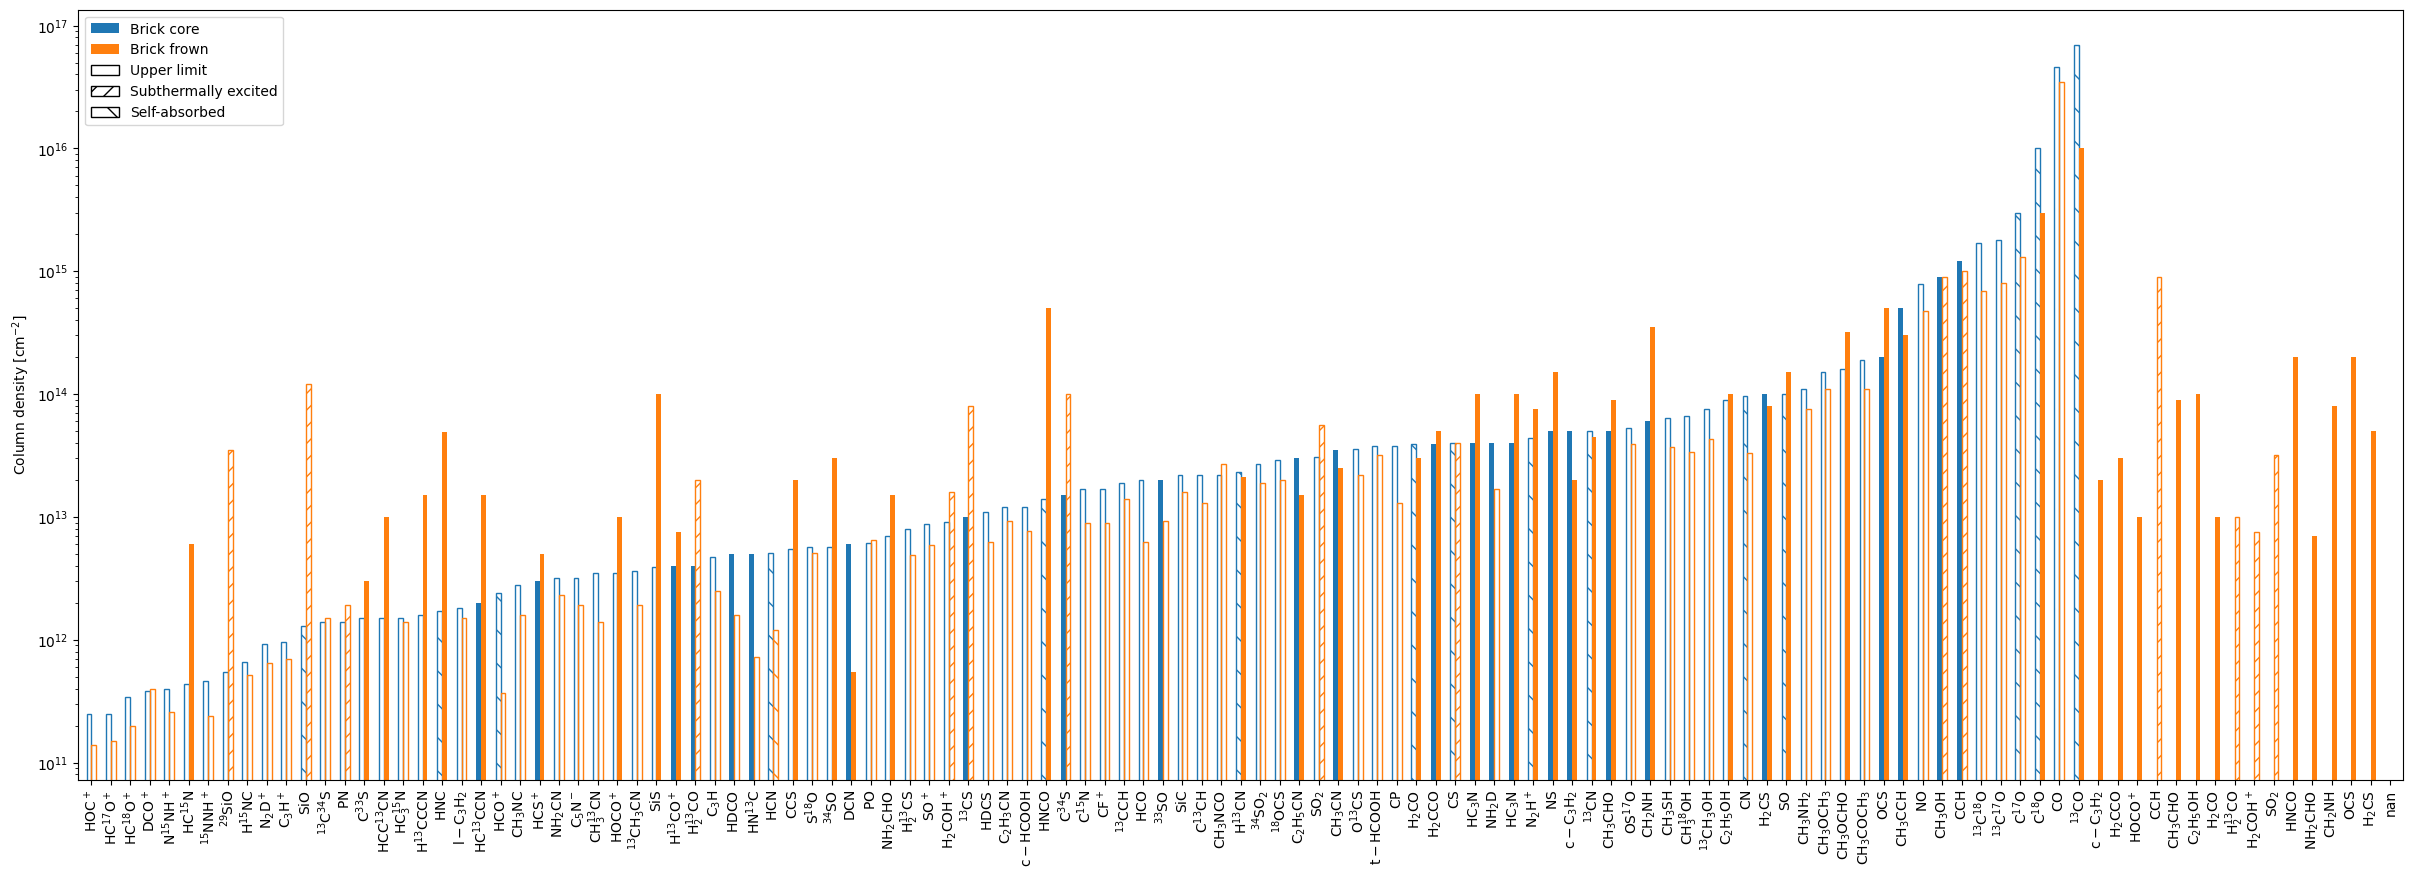

In [40]:
# Plot column density for each molecule in Brick core and frown, DSi/ii, and W51 core
fig = plt.figure(figsize = (30, 10))
align = 'edge' # center
x_axis = np.arange(len(tbl_sorted['core\nN_tot, cm^-2']))
new_x_axis = np.array([3*i for i in x_axis])
plt.xlim(np.min(new_x_axis)-2, np.max(new_x_axis)+2)
var_c = plt.bar(new_x_axis - 0.75, # - 0.5
                10**tbl_sorted['core\nN_tot, cm^-2'].astype('float'), width=0.75, align=align, label='Brick core', color='tab:blue') # width=0.25
var_f = plt.bar(new_x_axis, # - 0.25
                10**tbl_sorted['frown\nN_tot, cm^-2'].astype('float'), width=0.75, align=align, label='Brick frown', color='tab:orange') # width=0.25
# plt.bar(new_x_axis,
#         10**tbl_sorted['DSi_log10(Ntot)'], width=0.25, align=align, label='Sgr B2 DSi', color='tab:pink')
# plt.bar(new_x_axis + 0.25,
#         10**tbl_sorted['DSii_log10(Ntot)'], width=0.25, align=align, label='Sgr B2 DSii', color='tab:grey')
# plt.bar(new_x_axis + 0.5,
#         tbl_sorted['N_tot'], width=0.25, align=align, label='W51 core', color='tab:olive')
plt.yscale("log")
plt.xticks(new_x_axis, tbl_sorted['Species_latex'], rotation=90)
plt.ylabel(r"Column density [cm$^{-2}$]")
# Make legend
upper_limit = mpatches.Patch(edgecolor='k', facecolor='None', label='Upper limit')
subt_exc = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '//', label='Subthermally excited')
self_abs = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '\\', label='Self-absorbed')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(upper_limit)
handles.append(subt_exc)
handles.append(self_abs)
labels.append(upper_limit.get_label())
labels.append(subt_exc.get_label())
labels.append(self_abs.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
# Change marker types that are plotted
for rect,row in zip(var_c, Table.from_pandas(tbl_sorted)):
    if row['core'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['core'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['core'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
for rect,row in zip(var_f, Table.from_pandas(tbl_sorted)):
    if row['frown'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['frown'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['frown'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_all.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

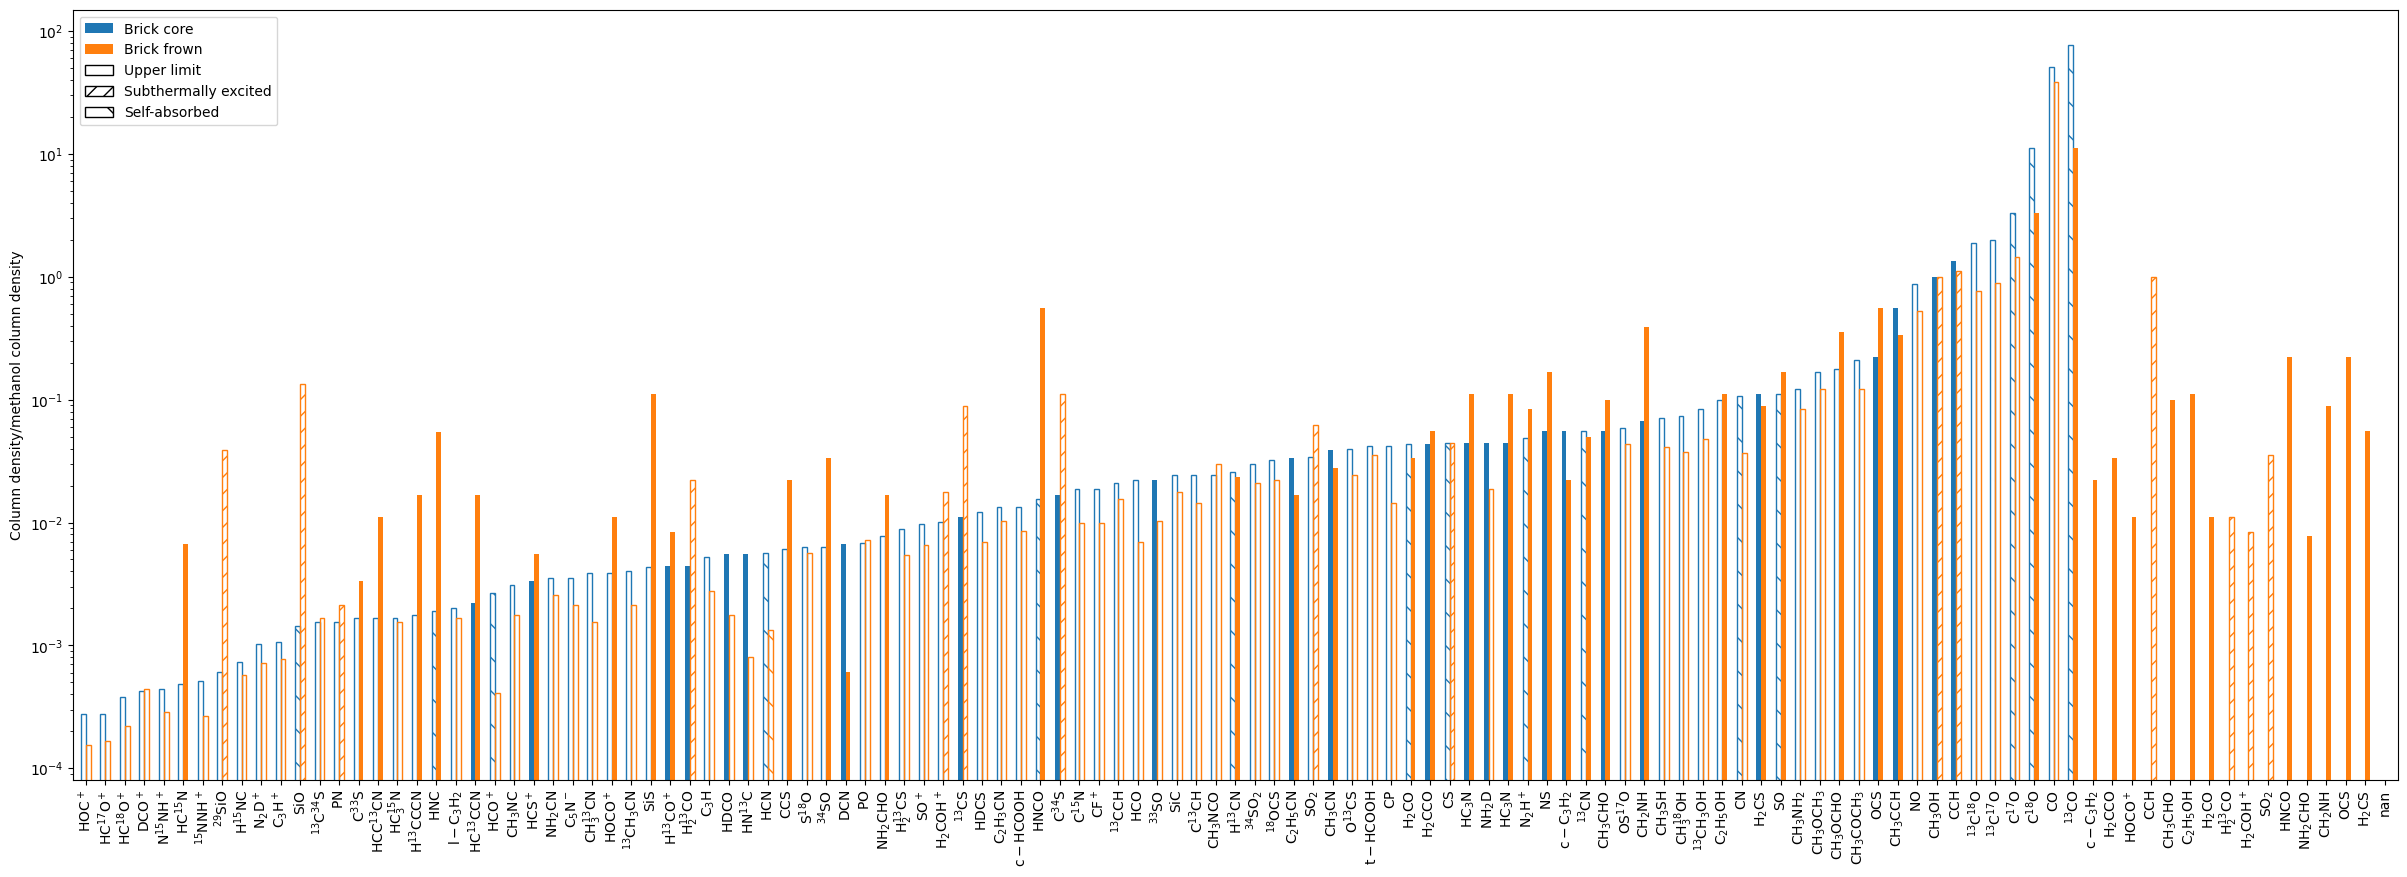

In [41]:
# Plot column density (normalized against methanol) for each molecule in Brick core and frown, DSi/ii, and W51 core
fig = plt.figure(figsize = (30, 10))
align = 'edge' # center
x_axis = np.arange(len(tbl_sorted['core\nN_tot, cm^-2']))
new_x_axis = np.array([3*i for i in x_axis])
plt.xlim(np.min(new_x_axis)-2, np.max(new_x_axis)+2)
var_c = plt.bar(new_x_axis - 0.75, # - 0.5
                10**tbl_sorted['core\nN_tot, cm^-2'].astype('float')/Ntot_methanol_core, width=0.75, align=align, label='Brick core', color='tab:blue') # width=0.25
var_f = plt.bar(new_x_axis, # - 0.25
                10**tbl_sorted['frown\nN_tot, cm^-2'].astype('float')/Ntot_methanol_frown, width=0.75, align=align, label='Brick frown', color='tab:orange') # width=0.25
# plt.bar(new_x_axis,
#         10**tbl_sorted['DSi_log10(Ntot)']/Ntot_methanol_d1, width=0.25, align=align, label='Sgr B2 DSi', color='tab:pink')
# plt.bar(new_x_axis + 0.25,
#         10**tbl_sorted['DSii_log10(Ntot)']/Ntot_methanol_d2, width=0.25, align=align, label='Sgr B2 DSii', color='tab:grey')
# plt.bar(new_x_axis + 0.5,
#         tbl_sorted['N_tot']/Ntot_methanol_cb, width=0.25, align=align, label='W51 core', color='tab:olive')
plt.yscale("log")
plt.xticks(new_x_axis, tbl_sorted['Species_latex'], rotation=90)
plt.ylabel("Column density/methanol column density")
# Make legend
upper_limit = mpatches.Patch(edgecolor='k', facecolor='None', label='Upper limit')
subt_exc = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '//', label='Subthermally excited')
self_abs = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '\\', label='Self-absorbed')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(upper_limit)
handles.append(subt_exc)
handles.append(self_abs)
labels.append(upper_limit.get_label())
labels.append(subt_exc.get_label())
labels.append(self_abs.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
# Change marker types that are plotted
for rect,row in zip(var_c, Table.from_pandas(tbl_sorted)):
    if row['core'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['core'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['core'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
for rect,row in zip(var_f, Table.from_pandas(tbl_sorted)):
    if row['frown'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['frown'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['frown'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_all_norm.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

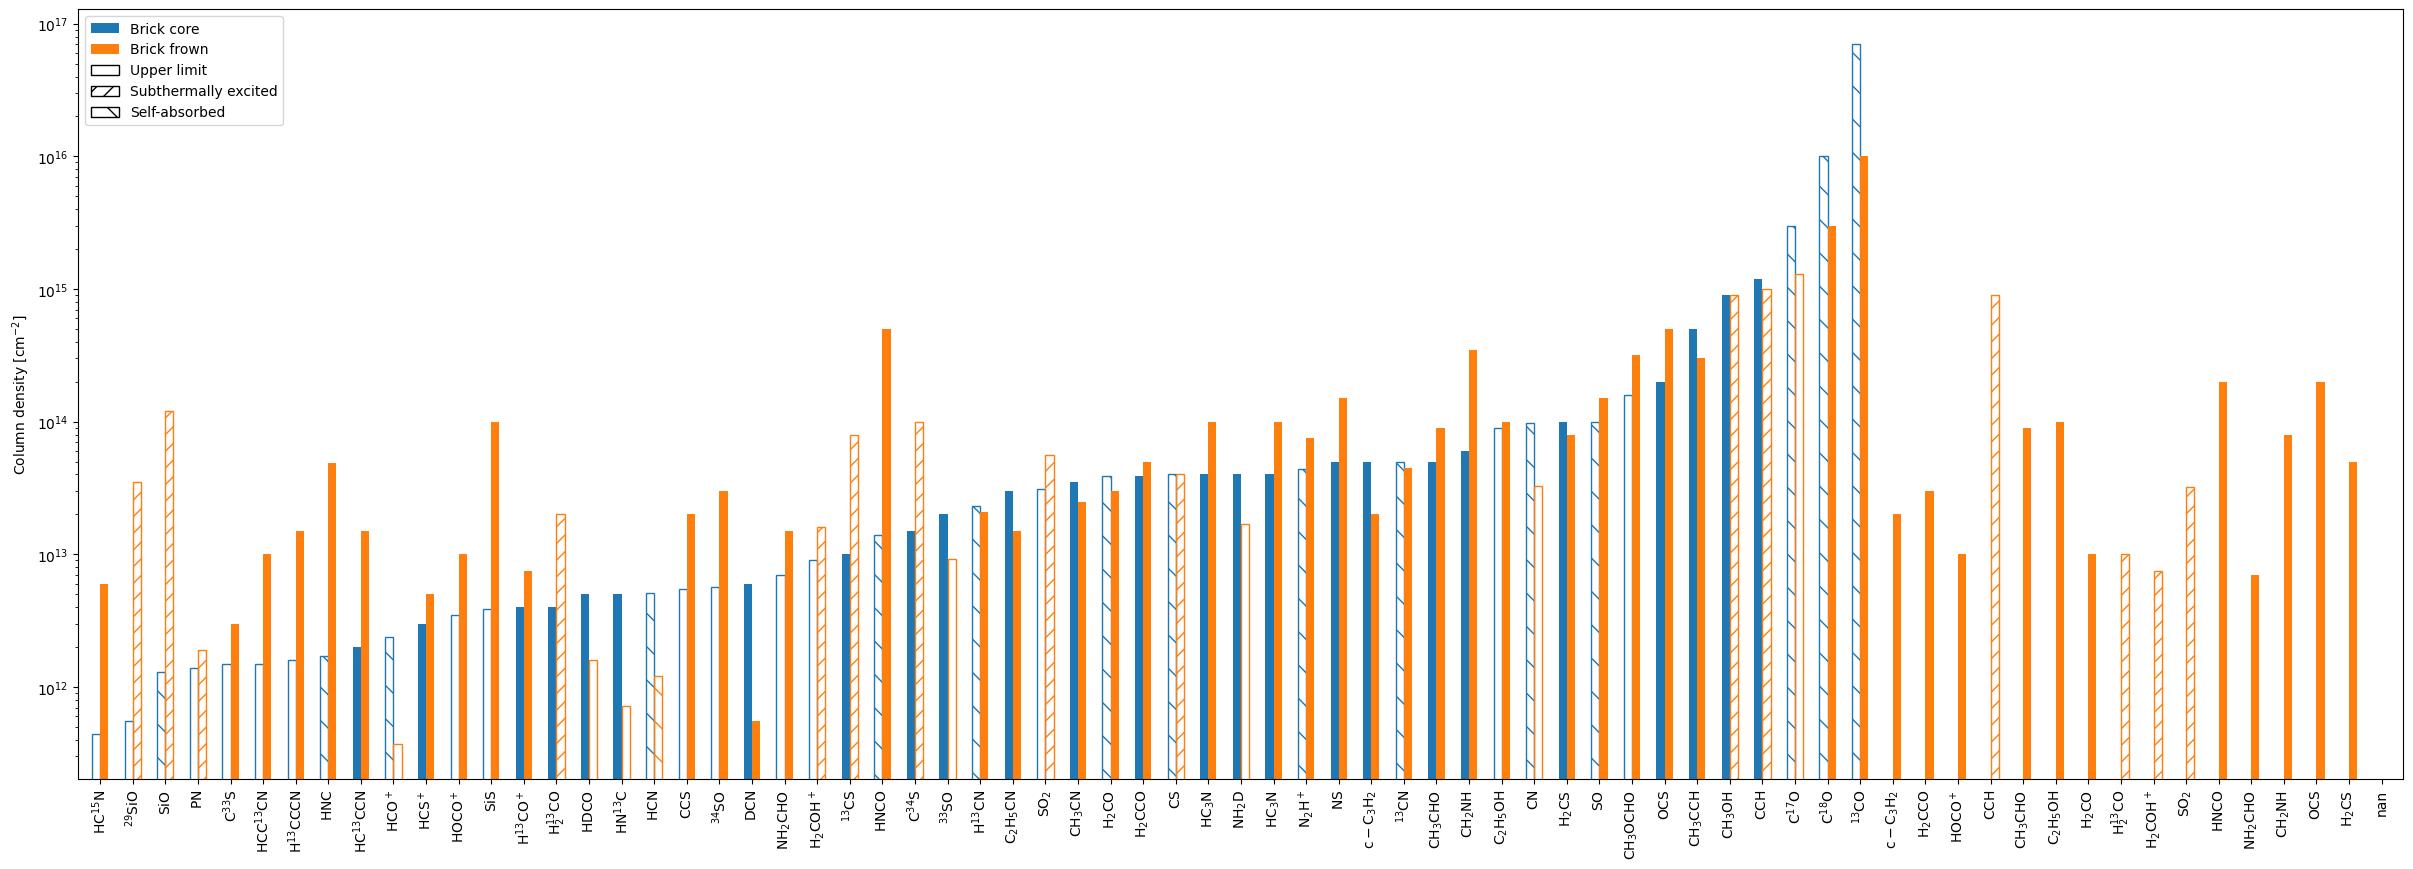

In [42]:
# Plot column density for each molecule in Brick core and frown, DSi/ii, and W51 core (JUST DETECTIONS)
fig = plt.figure(figsize = (30, 10))
align = 'edge' # center
x_axis = np.arange(len(tbl_noUL['core\nN_tot, cm^-2']))
new_x_axis = np.array([3*i for i in x_axis])
plt.xlim(np.min(new_x_axis)-2, np.max(new_x_axis)+2)
var_c = plt.bar(new_x_axis - 0.75, # - 0.5
                10**tbl_noUL['core\nN_tot, cm^-2'].astype('float'), width=0.75, align=align, label='Brick core', color='tab:blue') # width=0.25
var_f = plt.bar(new_x_axis, # - 0.25
                10**tbl_noUL['frown\nN_tot, cm^-2'].astype('float'), width=0.75, align=align, label='Brick frown', color='tab:orange') # width=0.25
# plt.bar(new_x_axis,
#         10**tbl_noUL['DSi_log10(Ntot)'], width=0.25, align=align, label='Sgr B2 DSi', color='tab:pink')
# plt.bar(new_x_axis + 0.25,
#         10**tbl_noUL['DSii_log10(Ntot)'], width=0.25, align=align, label='Sgr B2 DSii', color='tab:grey')
# plt.bar(new_x_axis + 0.5,
#         tbl_noUL['N_tot'], width=0.25, align=align, label='W51 core', color='tab:olive')
plt.yscale("log")
plt.xticks(new_x_axis, tbl_noUL['Species_latex'], rotation=90)
plt.ylabel(r"Column density [cm$^{-2}$]")
# Make legend
upper_limit = mpatches.Patch(edgecolor='k', facecolor='None', label='Upper limit')
subt_exc = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '//', label='Subthermally excited')
self_abs = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '\\', label='Self-absorbed')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(upper_limit)
handles.append(subt_exc)
handles.append(self_abs)
labels.append(upper_limit.get_label())
labels.append(subt_exc.get_label())
labels.append(self_abs.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
# Change marker types that are plotted
for rect,row in zip(var_c, Table.from_pandas(tbl_noUL)):
    if row['core'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['core'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['core'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
for rect,row in zip(var_f, Table.from_pandas(tbl_noUL)):
    if row['frown'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['frown'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['frown'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_det.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

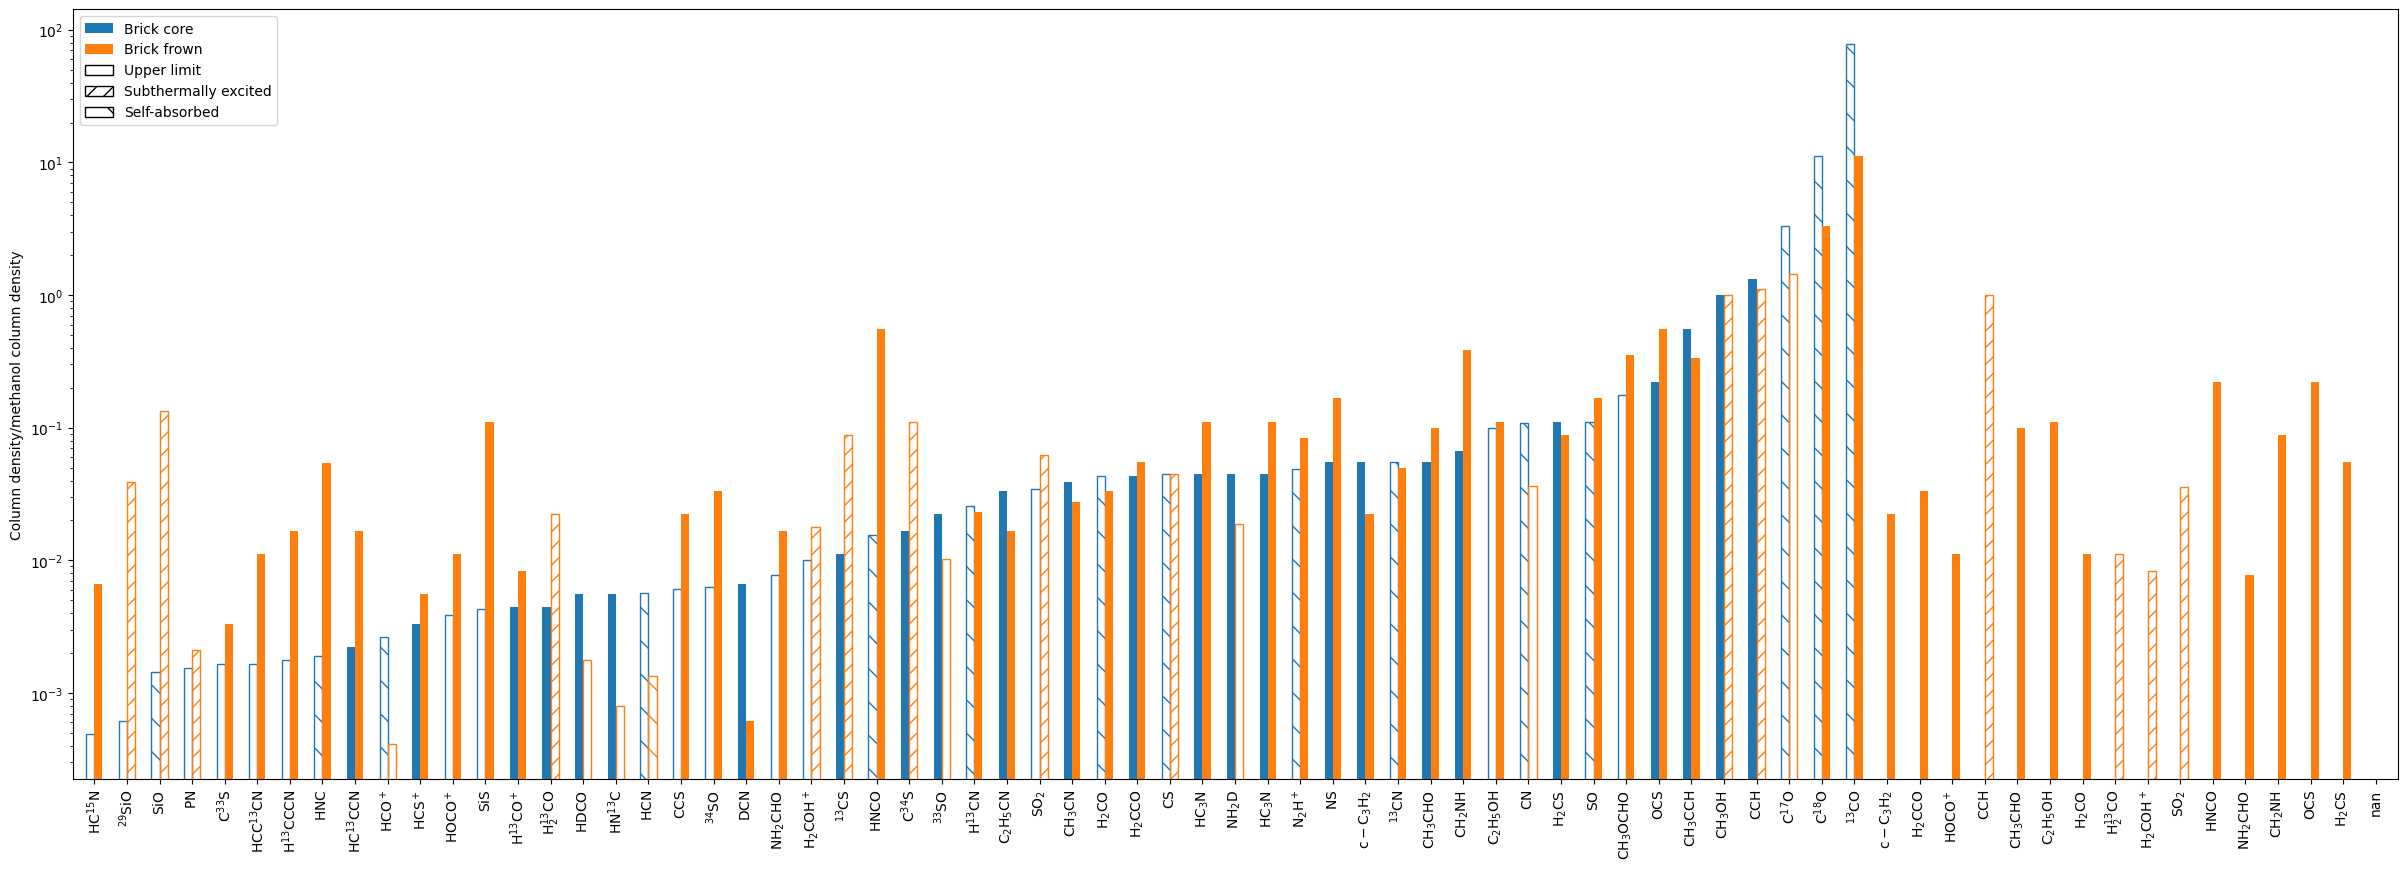

In [43]:
# Plot column density (normalized against methanol) for each molecule in Brick core and frown, DSi/ii, and W51 core (JUST DETECTIONS)
fig = plt.figure(figsize = (30, 10))
align = 'edge' # center
x_axis = np.arange(len(tbl_noUL['core\nN_tot, cm^-2']))
new_x_axis = np.array([3*i for i in x_axis])
plt.xlim(np.min(new_x_axis)-2, np.max(new_x_axis)+2)
var_c = plt.bar(new_x_axis - 0.75, # - 0.5
                10**tbl_noUL['core\nN_tot, cm^-2'].astype('float')/Ntot_methanol_core, width=0.75, align=align, label='Brick core', color='tab:blue') # width=0.25
var_f = plt.bar(new_x_axis, # - 0.25
                10**tbl_noUL['frown\nN_tot, cm^-2'].astype('float')/Ntot_methanol_frown, width=0.75, align=align, label='Brick frown', color='tab:orange') # width=0.25
# plt.bar(new_x_axis,
#         10**tbl_noUL['DSi_log10(Ntot)']/Ntot_methanol_d1, width=0.25, align=align, label='Sgr B2 DSi', color='tab:pink')
# plt.bar(new_x_axis + 0.25,
#         10**tbl_noUL['DSii_log10(Ntot)']/Ntot_methanol_d2, width=0.25, align=align, label='Sgr B2 DSii', color='tab:grey')
# plt.bar(new_x_axis + 0.5,
#         tbl_noUL['N_tot']/Ntot_methanol_cb, width=0.25, align=align, label='W51 core', color='tab:olive')
plt.yscale("log")
plt.xticks(new_x_axis, tbl_noUL['Species_latex'], rotation=90)
plt.ylabel("Column density/methanol column density")
# Make legend
upper_limit = mpatches.Patch(edgecolor='k', facecolor='None', label='Upper limit')
subt_exc = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '//', label='Subthermally excited')
self_abs = mpatches.Patch(edgecolor='k', facecolor='None', hatch = '\\', label='Self-absorbed')
handles, labels = fig.axes[0].get_legend_handles_labels()
handles.append(upper_limit)
handles.append(subt_exc)
handles.append(self_abs)
labels.append(upper_limit.get_label())
labels.append(subt_exc.get_label())
labels.append(self_abs.get_label())
plt.legend(handles, labels, fontsize=10, loc='upper left')
# Change marker types that are plotted
for rect,row in zip(var_c, Table.from_pandas(tbl_noUL)):
    if row['core'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['core'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['core'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
for rect,row in zip(var_f, Table.from_pandas(tbl_noUL)):
    if row['frown'] == 'UL':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
    if row['frown'] == 'ST':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('//')
    if row['frown'] == 'SA':
        rect.set_edgecolor(rect.get_facecolor())
        rect.set_facecolor('none')
        rect.set_hatch('\\')
plt.savefig("/blue/adamginsburg/abulatek/brick/first_results/figures/Ntot_det_norm.pdf", facecolor = 'w', edgecolor = 'w', bbox_inches = 'tight')
plt.show()

In [11]:
# Separate O-, S-, N-bearing for COMs, non-COMs in their own plots? Maybe ions in their own plot too?
# See https://ui.adsabs.harvard.edu/abs/2024A%26A...681A.104B/abstract